# Handwritten Digit Classification
### Gaussian Process Classification

#### Dataset Description ([Link to Data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html))

Each entry corresponds to one hand-written digit on 8x8 pixels. The dataset contains 1797 samples, with about 180 samples for each of the 10 classes (0-9). A Gaussian Process Classification using the Sliced Wasserstein Distance with an exponential kernels, where 10 models are trained for a One-v-Rest approach. We use PCA for direction optimizationand use both the probit and logit link function to convert the regression to classes. This example should replicated withou too much difficulty or time. Instead of training on global optimization, we sparsify the data and use an MCMC with 200 iterations.

In [ ]:
# !pip install gpcam

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

from fvgp import GP
from fvgp.gp_kernels import exponential_kernel

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from scipy.stats import wasserstein_distance
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [10]:
# 1. Load and Preprocess the Digits Dataset
digits = load_digits()
X, y = digits.data, digits.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [11]:
# 2. Create Sparse Datasets by Selecting Every 4th Sample
#X_train_sparse = X_train[::4]
#X_test_sparse = X_test[::4]
#y_train_sparse = y_train[::4]
#y_test_sparse = y_test[::4]

# Feature Scaling
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)


for i in range(len(X_train)): 
    X_train[i] = (X_train[i] - np.min(X_train[i])) + 1e-8
    X_train[i] =  X_train[i] / np.sum(X_train[i])

for i in range(len(X_test)): 
    X_test[i] = (X_test[i] - np.min(X_test[i])) + 1e-8
    X_test[i] =  X_test[i] / np.sum(X_test[i])

In [13]:
# Define the Logit Function
def logit(x):
    """
    Applies the logit function element-wise to the input array.
    
    Parameters:
    - x: ndarray
    
    Returns:
    - logit: ndarray
    """
    return 1 / (1 + np.exp(-x))

# Define Prediction Function using Logit
def predict_probs_logit(X_test, gp_models):
    """
    Predicts class probabilities for the test set using trained GP models with logit activation.
    
    Parameters:
    - X_test: (n_test, d) ndarray
    - gp_models: list of trained GP models
    
    Returns:
    - probabilities: (n_test, num_classes) ndarray
    """
    num_classes = len(gp_models)
    n_test = X_test.shape[0]
    logits = np.zeros((n_test, num_classes))

    for class_label, gp_model in enumerate(gp_models):
        # Compute the posterior mean for the test data
        posterior = gp_model.posterior_mean(X_test)
        mean = posterior["f(x)"]  # Extract mean predictions
        logits[:, class_label] = mean.flatten()

    # Apply logit to convert logits to probabilities
    probabilities = logit(logits)
    return probabilities

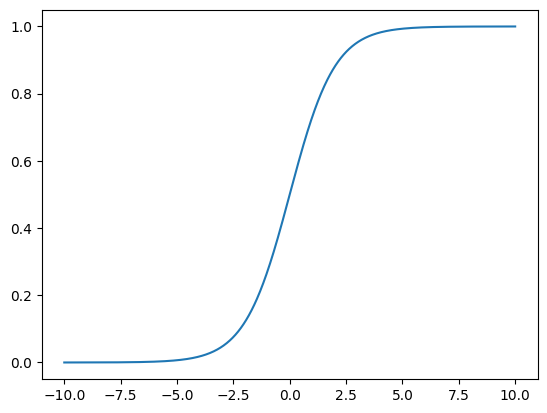

In [14]:
x = np.linspace(-10,10,1000)
plt.plot(x, logit(x))

In [15]:
# Define the Probit Function with Variance Incorporation
def probit_with_variance(mu, sigma2):
    """
    Applies the probit function with variance adjustment.
    
    Parameters:
    - mu: ndarray of shape (n_test, num_classes)
      Posterior means for each class.
    - sigma2: ndarray of shape (n_test, num_classes)
      Posterior variances for each class.
      
    Returns:
    - probabilities: ndarray of shape (n_test, num_classes)
      Adjusted probabilities for each class.
    """
    # Adjust the mean by incorporating variance
    adjusted_mu = mu / np.sqrt(1 + sigma2)
    return norm.cdf(adjusted_mu)

# Define Prediction Function using Probit Link with Variance
def predict_probs_probit_with_variance(X_test, gp_models):
    """
    Predicts class probabilities for the test set using trained GP models
    with probit activation, incorporating posterior variance.
    
    Parameters:
    - X_test: (n_test, d) ndarray
      Test data features.
    - gp_models: list of trained GP models
      One GP model per class.
      
    Returns:
    - probabilities: (n_test, num_classes) ndarray
      Class probabilities for each test sample.
    """
    num_classes = len(gp_models)
    n_test = X_test.shape[0]
    
    # Initialize arrays to store means and variances
    means = np.zeros((n_test, num_classes))
    variances = np.zeros((n_test, num_classes))
    
    for class_label, gp_model in enumerate(gp_models):
        # Compute the posterior mean for the test data
        posterior_mean = gp_model.posterior_mean(X_test)
        mean = posterior_mean["f(x)"]  # Extract mean predictions
        means[:, class_label] = mean.flatten()
        
        # Compute the posterior variance for the test data
        posterior_cov = gp_model.posterior_covariance(X_test, variance_only=True)
        variance = posterior_cov["v(x)"]  # Extract variances
        variances[:, class_label] = variance.flatten()
    
    # Apply probit with variance to convert means and variances to probabilities
    probabilities = probit_with_variance(means, variances)
    return probabilities

In [71]:
def KL(p,q):
    #print(p.shape, q.shape, (np.sum(p * np.log(p/q),axis=(1,2))).shape)
    return np.sum(p * np.log(p/q))

def JS(images1, images2):
    JS = np.zeros((len(images1), len(images2)))
    for i in range(len(images1)):
        for j in range(len(images2)):
            M = 0.5 * (images1[i] + images2[j])
            JS[i,j] = 0.5 * (KL(images1[i], M) + KL(images2[j], M))
            
    return JS

In [72]:
len(X_test)

180

In [73]:
JS_X_train = JS(X_train, X_train)
JS_X_test_kk = JS(X_test, X_test)
JS_X_test_k = JS(X_train, X_test)

In [87]:
# 3. Define the Sliced Wasserstein Exponential Kernel
def sliced_wasserstein_exponential_kernel_directions(X1, X2, hyperparameters, directions):
    """
    Computes the sliced Wasserstein exponential kernel using PCA directions for projections.

    Parameters:
    - X1: (n1, d) ndarray
    - X2: (n2, d) ndarray
    - hyperparameters: ndarray, contains [length_scale]
    - directions: (k, d) ndarray, selected directions

    Returns:
    - kernel_matrix: (n1, n2) ndarray
    """
    length_scale = hyperparameters[0]
    #X1 = X1.reshape(len(X1),8,8)
    #X2 = X2.reshape(len(X2),8,8)
    #print("kernel evaluated")
    

    if len(X1) == len(X2) == 1617: return hyperparameters[0] * exponential_kernel(JS_X_train, length_scale)
    if len(X1) == len(X2) == 180: return hyperparameters[0] * exponential_kernel(JS_X_test_kk, length_scale)
    else: return hyperparameters[0] * exponential_kernel(JS_X_test_k, length_scale)
        
    n1, d = X1.shape
    n2, _ = X2.shape
    k = directions.shape[0]  
    
    # Initialize the kernel matrix
    kernel_matrix = np.zeros((n1, n2))
    
    # Iterate over each PCA direction
    for dir_idx in range(k):
        direction = directions[dir_idx]
        
        # Project the data onto the current PCA direction
        proj_X1 = X1.dot(direction)  # Shape: (n1,)
        proj_X2 = X2.dot(direction)  # Shape: (n2,)
        
        # Compute the absolute differences between projections
        abs_diff = np.abs(proj_X1[:, np.newaxis] - proj_X2[np.newaxis, :])  # Shape: (n1, n2)
        
        # Apply the exponential kernel
        kernel_matrix += exponential_kernel(abs_diff, length_scale)
    
    # Average over all directions
    kernel_matrix /= k
    
    # Add jitter for numerical stability
    jitter = 1e-3
    if X1.shape[0] == X2.shape[0]:
        kernel_matrix += jitter * np.eye(X1.shape[0])
    
    return kernel_matrix

In [88]:
# 5. Initialize Hyperparameters and Bounds
initial_length_scale = 1.0  # Initial guess for length scale
init_hyperparameters = np.array([initial_length_scale])

# Define bounds for the length scale (e.g., between 0.1 and 10)
length_scale_bounds = np.array([[0.1, 10.0]])

In [89]:
#pca = PCA()
#pca.fit(X_train_scaled)

#cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#optimal_num_components = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because indices start at 0
#selected_directions_pca = pca.components_[:optimal_num_components]

In [90]:
#directions = selected_directions_pca
#k = directions.shape[0]
#print(k)
#for dir_idx in range(k):
#    direction = directions[dir_idx]
#    print((X_train_scaled.dot(direction).shape))

In [91]:
# Assuming the PCA directions are computed beforehand and stored in `selected_directions`
def sliced_wasserstein_exponential_kernel_wrapper_pca(x1, x2, hyperparameters):
    """
    Wrapper function to match the expected signature for the GP kernel.

    Parameters:
    - x1: (n1, d) ndarray
    - x2: (n2, d) ndarray
    - hyperparameters: ndarray, contains [length_scale]

    Returns:
    - kernel_matrix: (n1, n2) ndarray
    """
    # Use the previously computed PCA directions
    #return sliced_wasserstein_exponential_kernel_directions(x1, x2, hyperparameters, selected_directions_pca)
    return sliced_wasserstein_exponential_kernel_directions(x1, x2, hyperparameters, None)


In [94]:
# 6. Initialize and Train GP Models for Each Class using One-vs-Rest Strategy
gp_models_pca = []
num_classes = 10  # Digits 0-9

for class_label in range(num_classes):
    print(f"Training GP model for class {class_label}")

    # Binary labels for the current class
    y_train_binary = (y_train == class_label).astype(float)
    # Initialize GP model
    gp_model = GP(
        X_train,
        y_train_binary,
        init_hyperparameters=init_hyperparameters,
        gp_kernel_function=sliced_wasserstein_exponential_kernel_wrapper_pca,
        noise_variances=np.zeros(len(y_train_binary)) + 1e-6  # Noise variance
    )

    # Train the GP model using MCMC
    gp_model.train(
        hyperparameter_bounds=length_scale_bounds,
        method='mcmc',
        max_iter=1000,
        tolerance=1e-3,  
    )

    gp_models_pca.append(gp_model)
    print(f"GP model for class {class_label} trained.\n")


Training GP model for class 0
GP model for class 0 trained.

Training GP model for class 1
GP model for class 1 trained.

Training GP model for class 2
GP model for class 2 trained.

Training GP model for class 3
GP model for class 3 trained.

Training GP model for class 4
GP model for class 4 trained.

Training GP model for class 5
GP model for class 5 trained.

Training GP model for class 6
GP model for class 6 trained.

Training GP model for class 7
GP model for class 7 trained.

Training GP model for class 8
GP model for class 8 trained.

Training GP model for class 9
GP model for class 9 trained.



In [98]:
# Predict Probabilities using the Logit Link Function
gp_probabilities_logit_pca = predict_probs_logit(X_test, gp_models_pca)

# Predict Class Labels by Selecting the Class with the Highest Probability
gp_predictions_logit_pca = np.argmax(gp_probabilities_logit_pca, axis=1)

# Calculate Accuracy
gp_accuracy_logit_pca = accuracy_score(y_test, gp_predictions_logit_pca)

# 9. Evaluate the Classifier
print(f'PCA W-2 Logit Link – Accuracy: {gp_accuracy_logit_pca:.4f}\n')
print('Classification Report:')
print(classification_report(y_test, gp_predictions_logit_pca))


PCA W-2 Logit Link – Accuracy: 0.9944

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.95      1.00      0.97        18
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        18
           8       1.00      0.94      0.97        18
           9       1.00      1.00      1.00        18

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

